In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install lambeq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.1/152.1 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.9/144.9 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.3/364.3 kB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 82.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.5/103.5 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 46.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 72.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 28.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
else:
    print(gpu_info)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
DS_RESAMPLED_PATH = '/content/drive/MyDrive/Tesi/Master-Thesis/data/processed/promise-reclass_quantum.csv'
DS_NORMALIZED_PATH = '/content/drive/MyDrive/Tesi/Master-Thesis/data/processed/promise-reclass_classical.csv'

df = pd.read_csv(DS_NORMALIZED_PATH, index_col=False)

### Create diagrams

In [ ]:
def create_diagrams(df, reader):
  diagrams = []
  targets = []
  for _, row in enumerate(df.to_numpy()):
    sentence = row[0]
    target = row[1]
    try:
      diagram = reader.sentence2diagram(sentence)
    except Exception as e:
      print(e)
      continue
    diagrams.append(diagram)
    if target == "F":
      targets.append([1.0, 0.0])
    else:
      if target == "NF":
        targets.append([0.0, 1.0])
  return diagrams, targets

In [ ]:
from lambeq import stairs_reader, cups_reader, spiders_reader, BobcatParser, TreeReader, TreeReaderMode

tree_reader = TreeReader(ccg_parser=BobcatParser, mode = TreeReaderMode.RULE_TYPE)
# discocat_reader = BobcatParser()

diagrams, targets = create_diagrams(df, tree_reader)

Evaluating checksum: 0.0%|          |0.000/1.533GB [00:00<?]

Extracting model...
Bobcat failed to parse 'product shall provide scalability avoid service interruption ona day'.


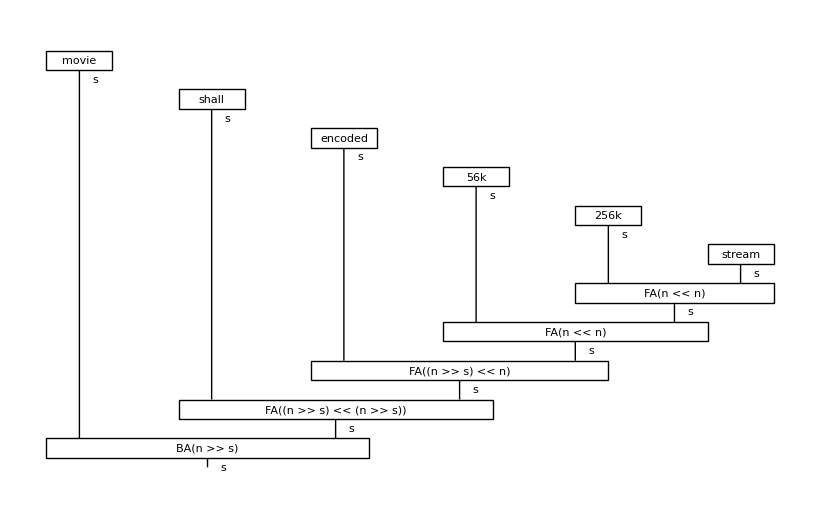

In [ ]:
diagrams[5].draw(figsize=(8,5), fontsize=8)

### Rewrite diagrams

In [ ]:
def normalize_diagrams(diagrams):
  normalized_diagrams = []
  for diagram in diagrams:

    # diagram = rewriter(diagram)
    # diagram = advanced_rewriter(diagram)
    # diagram = curry_functor(diagram)
    # diagram = diagram.normal_form()
    # diagram = remove_cups(diagram)

    normalized_diagrams.append(diagram)
  return normalized_diagrams

In [ ]:
from lambeq import Rewriter, remove_cups

rewriter = Rewriter(['prepositional_phrase',
                     'determiner'])

curry_functor = Rewriter(['curry'])

advanced_rewriter = Rewriter(['auxiliary',
                              'coordination',
                              'connector',
                              'object_rel_pronoun',
                              'subject_rel_pronoun',
                              'postadverb',
                              'preadverb'])

diagrams_normalized = normalize_diagrams(diagrams)

### Parametrize diagrams

In [ ]:
def create_circuits(diagrams, ansatz):
  circuits = []
  for i, diagram in enumerate(diagrams):
    try:
        circuit = ansatz(diagram)
    except Exception as e:
        print(e)
        continue
    # if circuit.cod != Dim(4):
    #     continue
    circuits.append(circuit)
  return circuits

In [ ]:
from lambeq import TensorAnsatz, MPSAnsatz, SpiderAnsatz, AtomicType
from discopy import Dim

N = AtomicType.NOUN
S = AtomicType.SENTENCE
P = AtomicType.PREPOSITIONAL_PHRASE
C = AtomicType.CONJUNCTION

SENTENCE_DIM = 4

tensor_ansatz = TensorAnsatz({S: Dim(SENTENCE_DIM)})

spider_ansatz = SpiderAnsatz({N: Dim(2),
                              S: Dim(SENTENCE_DIM)})

mps_ansatz = MPSAnsatz({N: Dim(2),
                        S: Dim(SENTENCE_DIM)},
                        bond_dim=3)

circuits = create_circuits(diagrams_normalized, tensor_ansatz)

ImportError: ignored

In [ ]:
circuits[5].draw(figsize=(8,5), fontsize=8)

## Training

### Define evaluation metrics

In [ ]:
sig = torch.sigmoid

def precision(y_hat, y):
    y_pred = torch.round(sig(y_hat))
    true_positives = torch.sum(y_pred * y)
    predicted_positives = torch.sum(y_pred)
    return true_positives / (predicted_positives + 1e-7)

def recall(y_hat, y):
    y_pred = torch.round(sig(y_hat))
    true_positives = torch.sum(y_pred * y)
    actual_positives = torch.sum(y)
    return true_positives / (actual_positives + 1e-7)

def accuracy(y_hat, y):
    y_pred = torch.round(sig(y_hat))
    correct_predictions = torch.sum(torch.eq(y_pred, y))
    return (correct_predictions / len(y))/2

def f1_score(y_hat, y):
    y_pred = torch.round(sig(y_hat))
    true_positives = torch.sum(y_pred * y)
    predicted_positives = torch.sum(y_pred)
    actual_positives = torch.sum(y)
    precision = true_positives / (predicted_positives + 1e-7)
    recall = true_positives / (actual_positives + 1e-7)
    return 2 * (precision * recall) / (precision + recall + 1e-7)

eval_metrics = {"acc": accuracy,
                "f1": f1_score}

### Define model

In [ ]:
from discopy.quantum.zx import X
from lambeq import PytorchModel
from torch import nn
import torch.nn.functional as F

# class qdelorean_cnn(PytorchModel):
#     def __init__(self):
#         super().__init__()

#         self.conv1 = nn.Conv1d(input_size, 128, kernel_size=3, padding="same")
#         self.fc1 = nn.Linear(128, 32)
#         self.drop3 = nn.Dropout(0.3)
#         self.fc2 = nn.Linear(32, 2)

#     def forward(self, input):
#         # perform tensor contraction
#         x = self.get_diagram_output(input)

#         x = x.unsqueeze(1)
#         x = x.permute(0, 2, 1)
#         x = self.conv1(x)
#         x = x.view(x.size(0), -1)
#         x = self.fc1(x)
#         x = self.drop3(x)
#         x = self.fc2(x)
#         return x

class qdelorean(PytorchModel):
    def __init__(self, hidden_size):
        super().__init__()

        self.fc1 = nn.Linear(SENTENCE_DIM, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 2)

    def forward(self, input):
        # perform tensor contraction
        x = self.get_diagram_output(input)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### Grid search & Cross Validation

In [ ]:
from datetime import datetime
from sklearn.model_selection import train_test_split, RepeatedKFold
from lambeq import Dataset, PytorchTrainer

SEED = 30
EPOCHS = 15

X_train, X_test, y_train, y_test = train_test_split(circuits, targets, test_size=0.2, random_state=SEED)

In [ ]:
def gridsearch_experiment(bs, lr, hs):

    X_train_grid, X_val_grid, y_train_grid, y_val_grid = train_test_split(X_train, y_train, test_size=0.2, random_state=SEED)

    train_dataset = Dataset(X_train_grid, y_train_grid, batch_size=bs)
    val_dataset =  Dataset(X_val_grid, y_val_grid, shuffle=False)

    model = qdelorean.from_diagrams(circuits, hidden_size=hs).to(device)

    trainer = PytorchTrainer(model=model,
                            loss_function=torch.nn.BCEWithLogitsLoss(),
                            optimizer=torch.optim.AdamW,
                            learning_rate=lr,
                            evaluate_functions=eval_metrics,
                            epochs=EPOCHS,
                            verbose='progress',
                            device=0,
                            seed=SEED)

    trainer.fit(train_dataset, val_dataset, evaluation_step=1)

    train_score = trainer.train_results['acc']
    val_score = trainer.val_results['acc']

    return train_score, val_score

In [ ]:
best_val_acc = 0

best_bs = 0 # batch_size
best_lr = 0 # learning_rate
best_hs = 0 # hidden_size

batch_sizes = [32]
learning_rates = [7e-2, 3e-2, 1e-2]
hidden_sizes = [8, 32, 128, 256]

i = 0
total_config = len(batch_sizes)*len(learning_rates)*len(hidden_sizes)

for bs in batch_sizes:
    for lr in learning_rates:
        for hs in hidden_sizes:
            i += 1
            print(f"[{i}/{total_config}] Using: bs={bs}, learning_rate={lr}, hidden_size={hs}")

            train_acc, val_acc = gridsearch_experiment(bs, lr, hs)

            fig, ax = plt.subplots(figsize=(4, 2))

            ax.set_title('Accuracy')
            ax.set_xlabel('Epochs')
            train_results_acc = torch.tensor(train_acc).cpu()
            val_results_acc = torch.tensor(val_acc).cpu()

            colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
            ax.plot(train_results_acc, color=next(colours), label='Training')
            ax.plot(val_results_acc, color=next(colours), label='Validation')

            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.tight_layout()
            plt.show()

            if val_acc[EPOCHS-1] > best_val_acc:
                best_val_acc = val_acc[EPOCHS-1]
                best_bs = bs
                best_lr = lr
                best_hs = hs

print(f"Best hyperparameters: batch_size={best_bs}, learning_rate={best_lr} , hidden_sizes={best_hs} - accuracy={best_val_acc}")

In [ ]:
cross_validation = True
if cross_validation:
    train_dataset = Dataset(X_train, y_train, batch_size=best_bs)

    cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=SEED)
    fold_val_scores = []

    for i, (train_index, val_index) in enumerate(cv.split(train_dataset)):

        print(f'Fold {i}:')

        train_fold = Dataset(np.array(X_train)[train_index], np.array(y_train)[train_index], batch_size=best_bs)
        val_fold = Dataset(np.array(X_train)[val_index], np.array(y_train)[val_index])

        model = qdelorean.from_diagrams(circuits, hidden_size=best_hs).to(device)

        trainer = PytorchTrainer(model=model,
                                    loss_function=torch.nn.BCEWithLogitsLoss(),
                                    optimizer=torch.optim.AdamW,
                                    learning_rate=best_lr,
                                    evaluate_functions=eval_metrics,
                                    epochs=EPOCHS,
                                    verbose='progress',
                                    device=0,
                                    seed=SEED)

        trainer.fit(train_fold, val_fold, evaluation_step=1)
        val_score = trainer.val_results['acc'][EPOCHS - 1]
        fold_val_scores.append(val_score.item())

    print(f'CV mean accuracy: {np.mean(fold_val_scores)}')

### Train model

In [ ]:
train_dataset = Dataset(X_train, y_train, batch_size=best_bs)

model = qdelorean.from_diagrams(circuits, hidden_size=best_hs).to(device)

trainer = PytorchTrainer(model=model,
                        loss_function=torch.nn.BCEWithLogitsLoss(),
                        optimizer=torch.optim.AdamW,
                        learning_rate=best_lr,
                        epochs=EPOCHS,
                        evaluate_functions=eval_metrics,
                        verbose='text',
                        device=0,
                        use_tensorboard=True,
                        seed=SEED)

trainer.fit(train_dataset)

fig, axes = plt.subplots(1, 3, figsize=(6, 2))

axes[0].set_title('Training Accuracy')
axes[0].set_xlabel('Epochs')
train_results_acc = torch.tensor(trainer.train_results['acc']).cpu()
colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
axes[0].plot(train_results_acc, color=next(colours))

axes[1].set_title('Training Loss')
axes[1].set_xlabel('Epochs')
train_results_loss = torch.tensor(trainer.train_epoch_costs).cpu()
axes[1].plot(train_results_loss, color=next(colours))

axes[2].set_title('Training F1-Score')
axes[2].set_xlabel('Epochs')
train_results_f1 = torch.tensor(trainer.train_results['f1']).cpu()
axes[2].plot(train_results_f1, color=next(colours))

plt.show()

## Testing & Results

In [ ]:
test_acc = accuracy(model.forward(X_test), torch.tensor(y_test))
print('Test accuracy:', test_acc.item())

test_f1 = f1_score(model.forward(X_test), torch.tensor(y_test))
print('Test f1_score:', test_f1.item())

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

predicted_labels = ['Non-Functional', 'Functional']

predictions_np = model.forward(X_test).cpu().detach().numpy()
labels_np = torch.tensor(y_test).cpu().detach().numpy()

predicted_classes = np.argmax(predictions_np, axis=1)
true_classes = np.argmax(labels_np, axis=1)

cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=predicted_labels, yticklabels=predicted_labels)
plt.title("Confusion Matrix - Test set")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

## Save Model

In [ ]:
MODEL_PATH ='model/qdelorean_model.pt'
torch.save(model.state_dict(), MODEL_PATH)

## Load Tensorboard

In [ ]:
%load_ext tensorboard
%reload_ext tensorboard
%tensorboard --logdir runs